In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure

In [ ]:
# Define the UNet model architecture with Sigmoid activation for RGB output
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = self.conv_block(1, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 1024)
        
        self.up1 = self.upconv_block(1024, 512)
        self.up2 = self.upconv_block(1024, 256)
        self.up3 = self.upconv_block(512, 128)
        self.up4 = self.upconv_block(256, 64)
        self.final_depth = nn.Conv2d(128, 1, kernel_size=1)  # Depth map output
        self.final_rgb = nn.Conv2d(128, 3, kernel_size=1)    # RGB image output
        
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for RGB output
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        
        up1 = self.up1(d5)
        up1 = torch.cat((up1, d4), dim=1)
        up2 = self.up2(up1)
        up2 = torch.cat((up2, d3), dim=1)
        up3 = self.up3(up2)
        up3 = torch.cat((up3, d2), dim=1)
        up4 = self.up4(up3)
        up4 = torch.cat((up4, d1), dim=1)
        
        depth_output = self.final_depth(up4)
        rgb_output = self.sigmoid(self.final_rgb(up4))  # Apply Sigmoid activation
        
        return depth_output, rgb_output


In [ ]:
# Dataset class
class ChairDataset(Dataset):
    def __init__(self, edge_dir, depth_dir, rgb_dir, transform=None):
        self.edge_dir = edge_dir
        self.depth_dir = depth_dir
        self.rgb_dir = rgb_dir
        self.transform = transform
        self.edge_files = os.listdir(edge_dir)
        self.valid_files = self._filter_valid_files()
    
    def _filter_valid_files(self):
        valid_files = []
        for filename in self.edge_files:
            edge_path = os.path.join(self.edge_dir, filename)
            depth_path = os.path.join(self.depth_dir, filename)
            rgb_path = os.path.join(self.rgb_dir, filename)
            if os.path.exists(edge_path) and os.path.exists(depth_path) and os.path.exists(rgb_path):
                valid_files.append(filename)
        return valid_files
    
    def __len__(self):
        return len(self.valid_files)
    
    def __getitem__(self, idx):
        filename = self.valid_files[idx]
        edge_path = os.path.join(self.edge_dir, filename)
        depth_path = os.path.join(self.depth_dir, filename)
        rgb_path = os.path.join(self.rgb_dir, filename)
        
        edge = Image.open(edge_path).convert('L')
        depth = Image.open(depth_path).convert('L')
        rgb = Image.open(rgb_path).convert('RGB')
        
        if self.transform:
            edge = self.transform(edge)
            depth = self.transform(depth)
            rgb = self.transform(rgb)
        
        return edge, depth, rgb


In [ ]:
def train_model(model, dataloader, criterion_depth, criterion_rgb, optimizer, num_epochs=10, device='cuda', depth_weight=1.0, rgb_weight=1.0):
    model.to(device)  # Move the model to the specified device
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):
        running_loss_depth = 0.0
        running_loss_rgb = 0.0
        
        total_samples = 0
        correct_depth_predictions = 0  # Placeholder for depth accuracy
        correct_rgb_predictions = 0    # Placeholder for RGB accuracy
        
        for i, data in enumerate(dataloader, 0):
            inputs, depth_targets, rgb_targets = data
            
            # Move inputs and targets to the same device as the model
            inputs = inputs.to(device)
            depth_targets = depth_targets.to(device)
            rgb_targets = rgb_targets.to(device)
            
            # Forward pass
            depth_outputs, rgb_outputs = model(inputs)
            
            # Resize targets to match the output sizes
            depth_targets_resized = F.interpolate(depth_targets, size=depth_outputs.shape[2:], mode='bilinear', align_corners=False)
            rgb_targets_resized = F.interpolate(rgb_targets, size=rgb_outputs.shape[2:], mode='bilinear', align_corners=False)
            
            # Compute losses
            loss_depth = criterion_depth(depth_outputs, depth_targets_resized)
            loss_rgb = criterion_rgb(rgb_outputs, rgb_targets_resized)
            loss = depth_weight * loss_depth + rgb_weight * loss_rgb

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update loss statistics
            running_loss_depth += loss_depth.item()
            running_loss_rgb += loss_rgb.item()

            total_samples += inputs.size(0)

        # Print average loss for the epoch
        avg_loss_depth = running_loss_depth / len(dataloader)
        avg_loss_rgb = running_loss_rgb / len(dataloader)
        print(f"[Epoch {epoch + 1}] Avg Loss Depth: {avg_loss_depth:.3f}, Avg Loss RGB: {avg_loss_rgb:.3f}")

    print('Finished Training')

# Data transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset paths
edge_dir = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\edge'
depth_dir = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\depth'
rgb_dir = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\rgb_png'

# Dataset and DataLoader
dataset = ChairDataset(edge_dir, depth_dir, rgb_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model, loss functions, and optimizer
model = UNet().cuda()
criterion_depth = nn.MSELoss()
criterion_rgb = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [13]:
# Train the model with balanced loss weights
train_model(model, dataloader, criterion_depth, criterion_rgb, optimizer, num_epochs=20, depth_weight=1.0, rgb_weight=1.0)


[Epoch 1] Avg Loss Depth: 0.046, Avg Loss RGB: 0.038
[Epoch 2] Avg Loss Depth: 0.025, Avg Loss RGB: 0.015
[Epoch 3] Avg Loss Depth: 0.018, Avg Loss RGB: 0.009
[Epoch 4] Avg Loss Depth: 0.015, Avg Loss RGB: 0.007
[Epoch 5] Avg Loss Depth: 0.012, Avg Loss RGB: 0.005
[Epoch 6] Avg Loss Depth: 0.011, Avg Loss RGB: 0.004
[Epoch 7] Avg Loss Depth: 0.009, Avg Loss RGB: 0.004
[Epoch 8] Avg Loss Depth: 0.008, Avg Loss RGB: 0.003
[Epoch 9] Avg Loss Depth: 0.007, Avg Loss RGB: 0.003
[Epoch 10] Avg Loss Depth: 0.007, Avg Loss RGB: 0.003
[Epoch 11] Avg Loss Depth: 0.006, Avg Loss RGB: 0.002
[Epoch 12] Avg Loss Depth: 0.006, Avg Loss RGB: 0.002
[Epoch 13] Avg Loss Depth: 0.005, Avg Loss RGB: 0.002
[Epoch 14] Avg Loss Depth: 0.005, Avg Loss RGB: 0.002
[Epoch 15] Avg Loss Depth: 0.004, Avg Loss RGB: 0.002
[Epoch 16] Avg Loss Depth: 0.004, Avg Loss RGB: 0.002
[Epoch 17] Avg Loss Depth: 0.004, Avg Loss RGB: 0.002
[Epoch 18] Avg Loss Depth: 0.004, Avg Loss RGB: 0.002
[Epoch 19] Avg Loss Depth: 0.003, Avg

In [14]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'model_weights.pth')

In [15]:
# Define the UNet model architecture with Sigmoid activation for RGB output
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = self.conv_block(1, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 1024)
        
        self.up1 = self.upconv_block(1024, 512)
        self.up2 = self.upconv_block(1024, 256)
        self.up3 = self.upconv_block(512, 128)
        self.up4 = self.upconv_block(256, 64)
        self.final_depth = nn.Conv2d(128, 1, kernel_size=1)  # Depth map output
        self.final_rgb = nn.Conv2d(128, 3, kernel_size=1)    # RGB image output
        
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for RGB output
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        
        up1 = self.up1(d5)
        up1 = torch.cat((up1, d4), dim=1)
        up2 = self.up2(up1)
        up2 = torch.cat((up2, d3), dim=1)
        up3 = self.up3(up2)
        up3 = torch.cat((up3, d2), dim=1)
        up4 = self.up4(up3)
        up4 = torch.cat((up4, d1), dim=1)
        
        depth_output = self.final_depth(up4)
        rgb_output = self.sigmoid(self.final_rgb(up4))  # Apply Sigmoid activation
        
        return depth_output, rgb_output

# Function to load an image, perform transformations, and get model predictions
def generate_images(model, edge_image_path, depth_output_path, rgb_output_path, transform=None, device='cuda'):
    model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode
    
    # Load and transform the edge image
    edge_image = Image.open(edge_image_path).convert('L')
    if transform:
        edge_image = transform(edge_image)
    edge_image = edge_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Get model predictions
    with torch.no_grad():
        depth_output, rgb_output = model(edge_image)
    
    # Convert outputs to images
    depth_output = depth_output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
    rgb_output = rgb_output.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and move to CPU
    
    # Save depth output
    plt.imsave(depth_output_path, depth_output[0], cmap='gray')
    
    # Normalize and save RGB output
    rgb_output = (rgb_output - rgb_output.min()) / (rgb_output.max() - rgb_output.min())  # Normalize to [0, 1]
    plt.imsave(rgb_output_path, rgb_output)
    
    print(f"Generated images saved to {depth_output_path} and {rgb_output_path}")

# Example usage
edge_image_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\edge\1.png'
depth_output_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_depth.png'
rgb_output_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_rgb.png'

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load the trained model
load_model = UNet()
load_model.load_state_dict(torch.load('model_weights_2.pth'))

# Generate images
generate_images(load_model, edge_image_path, depth_output_path, rgb_output_path, transform=transform)

Generated images saved to D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_depth.png and D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_rgb.png


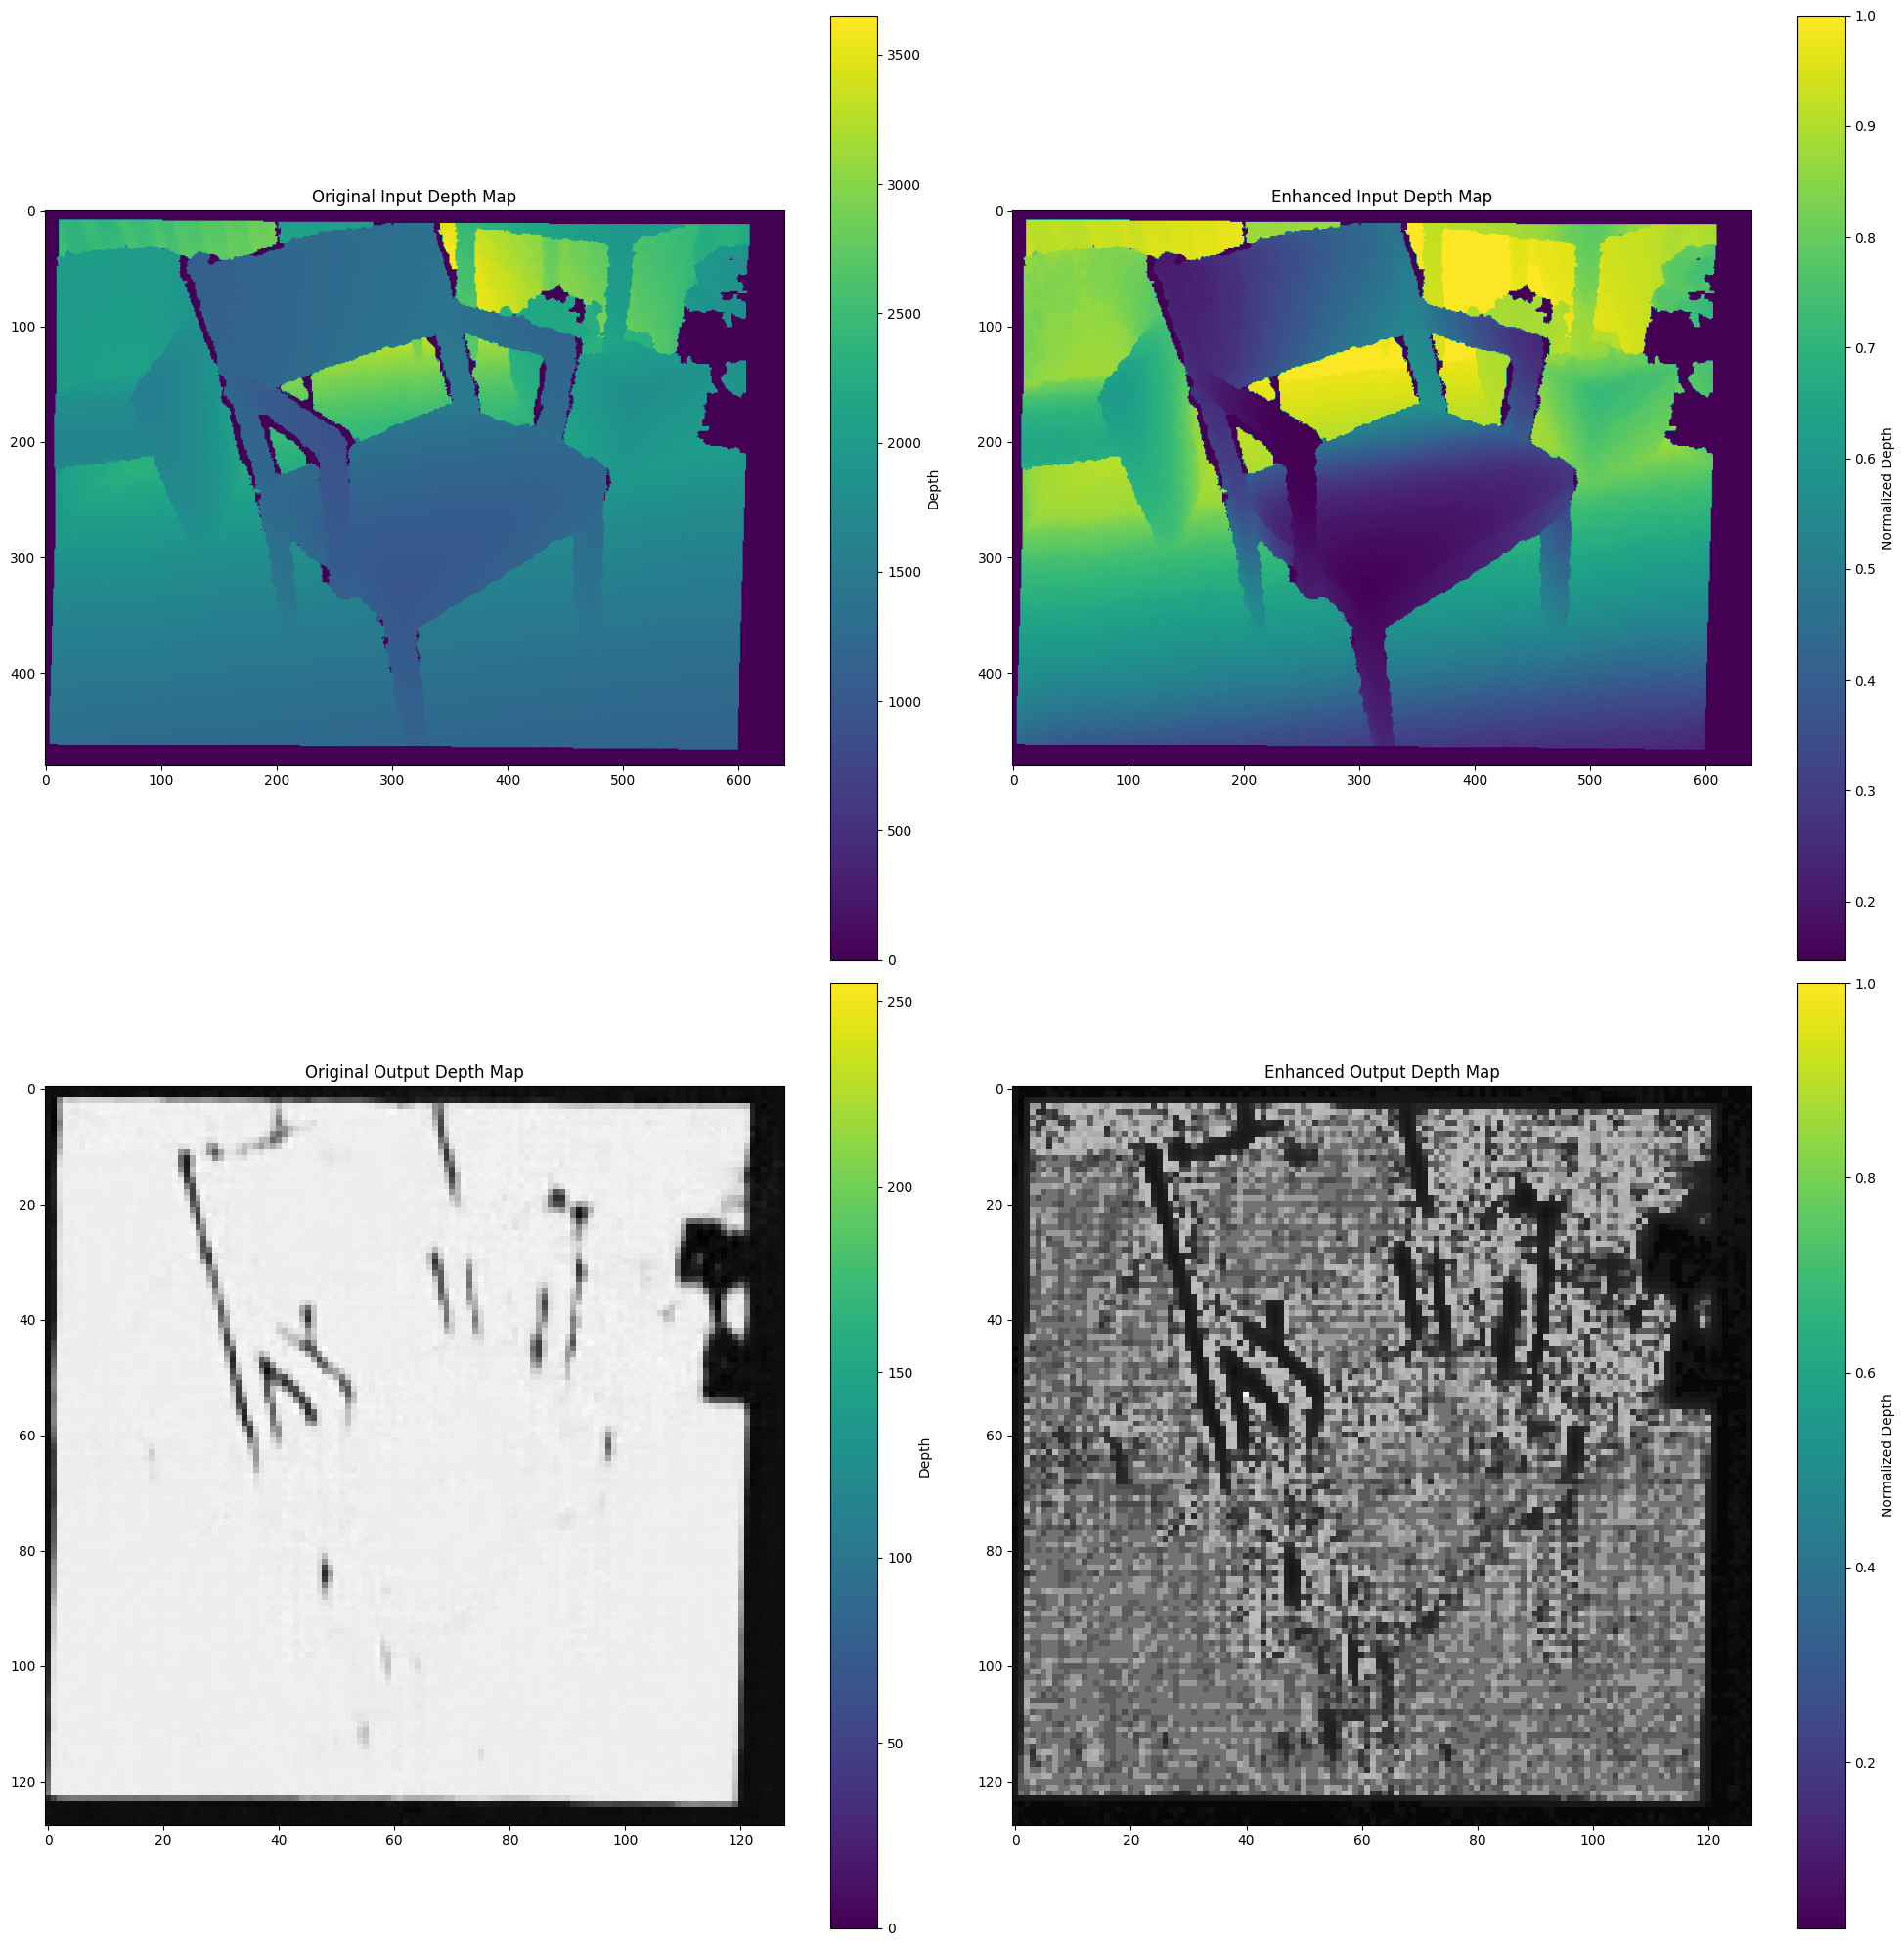

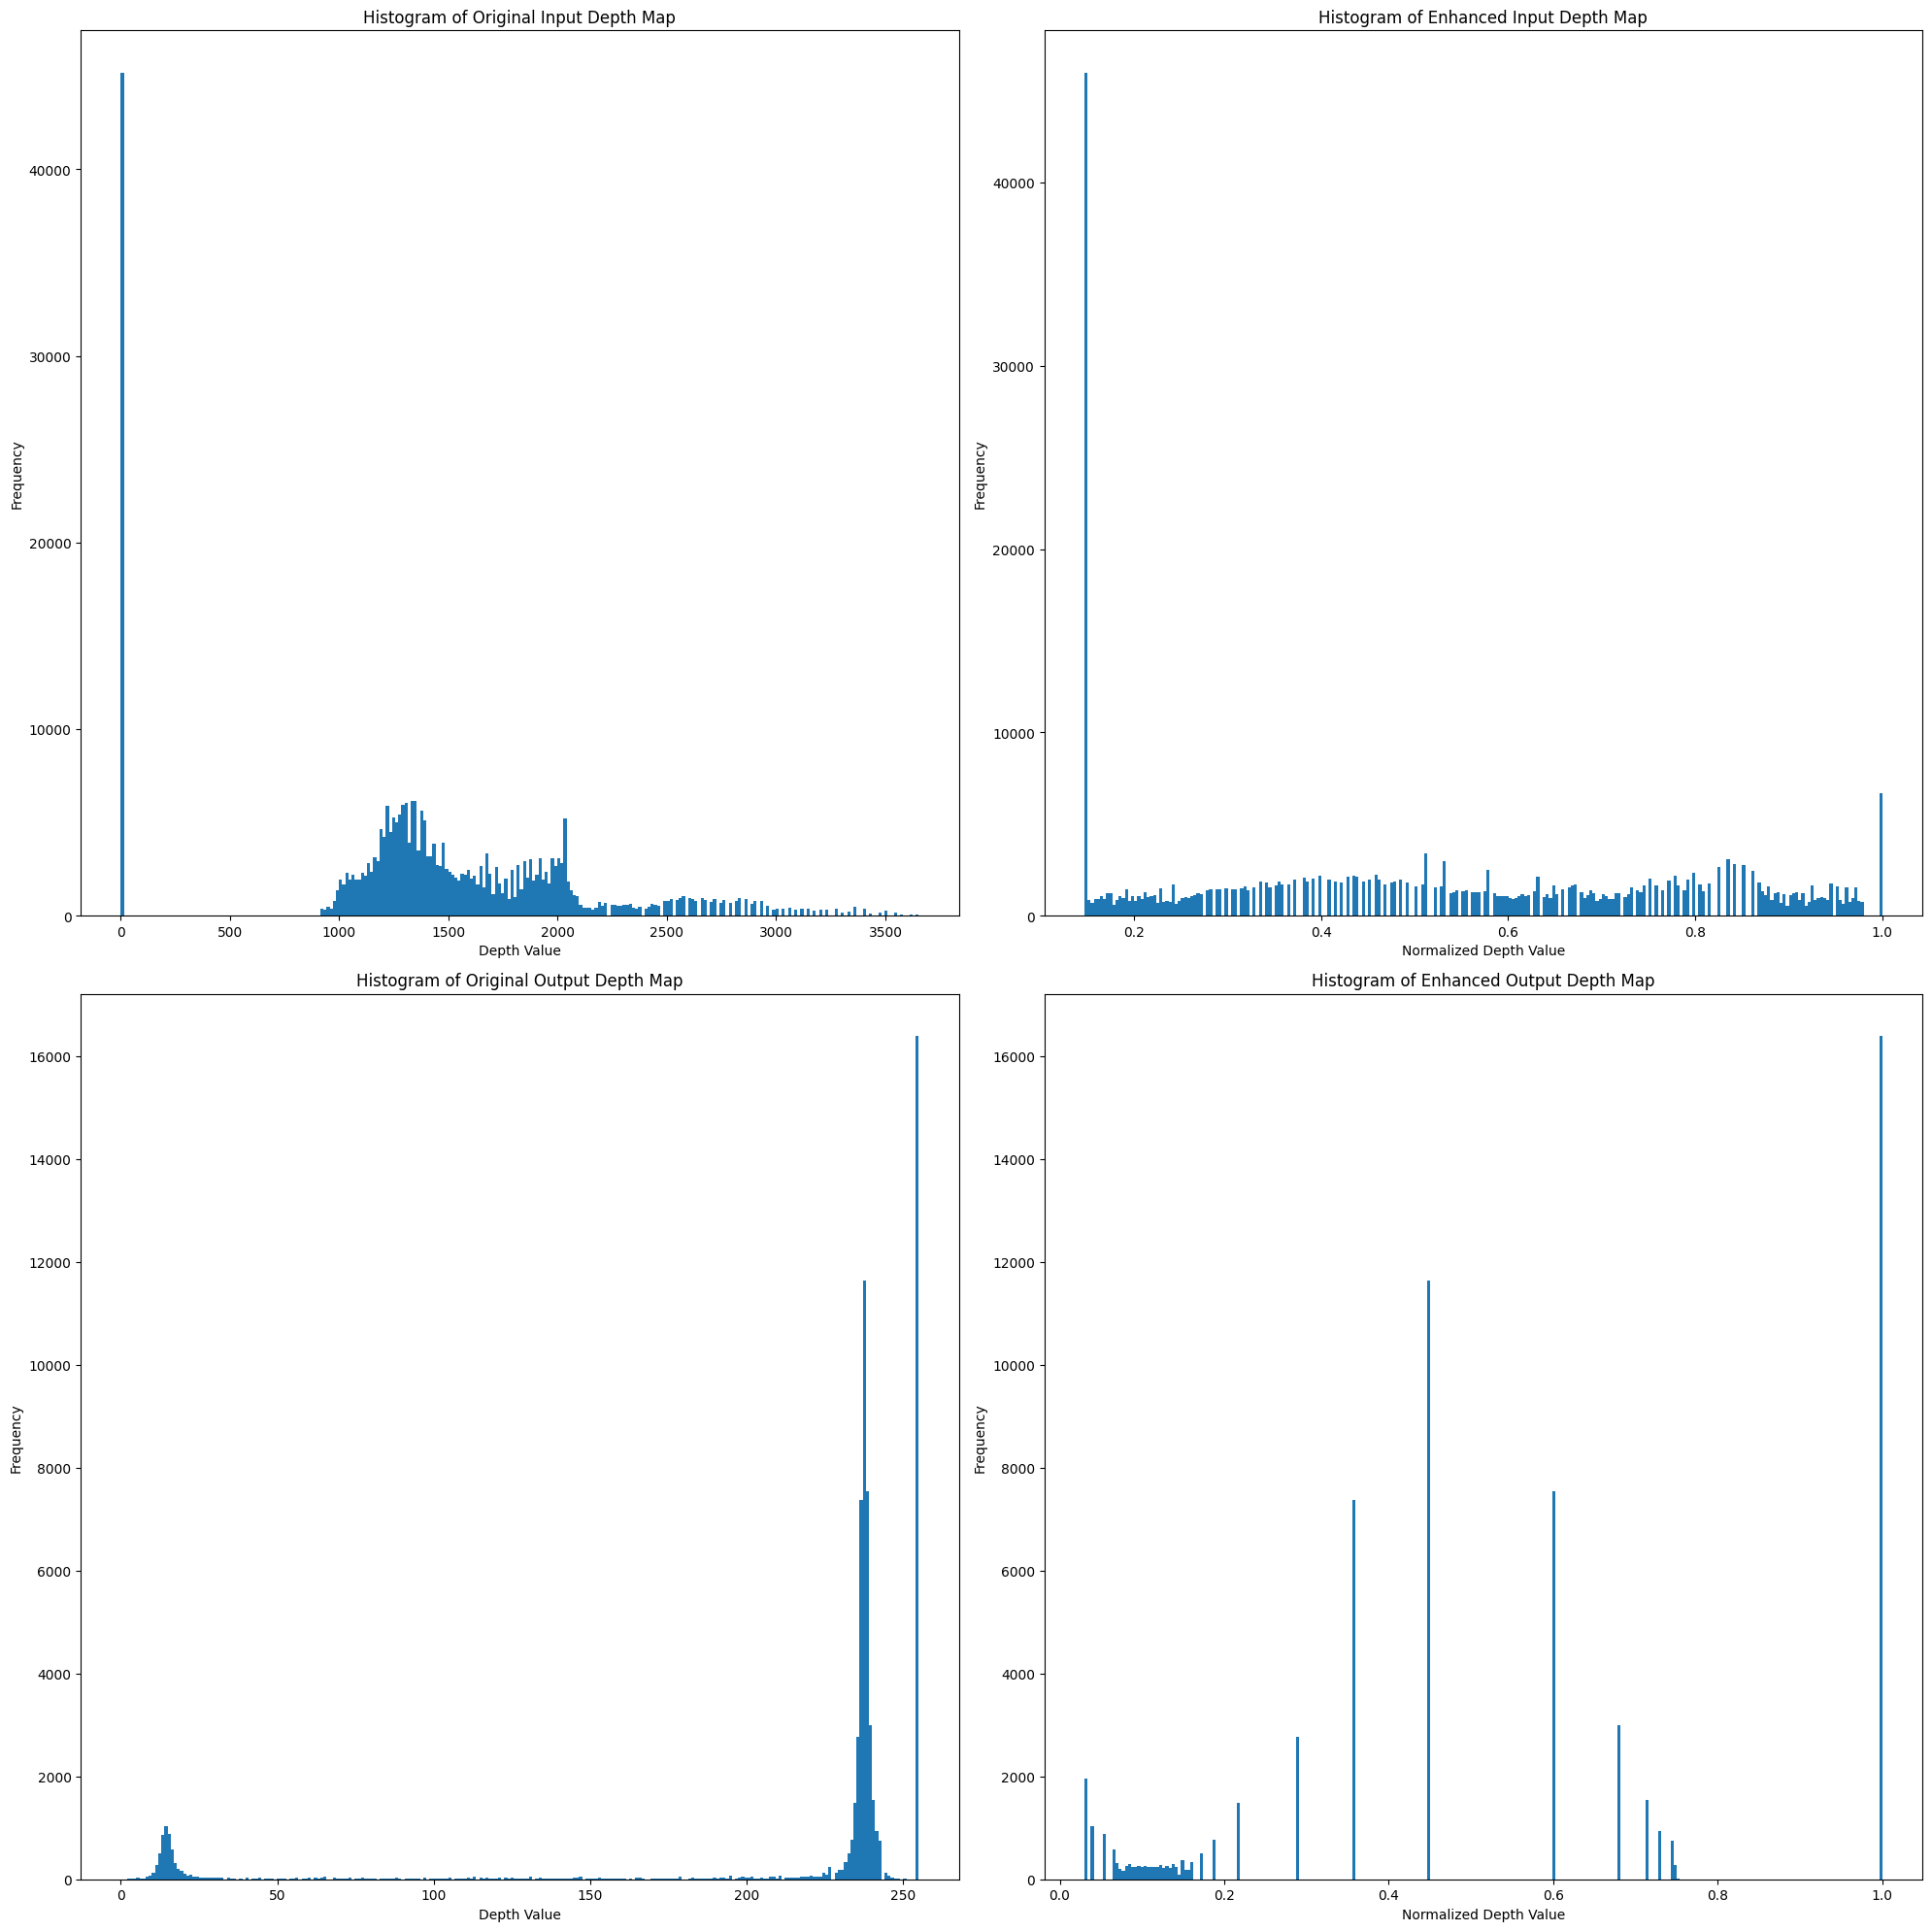

Statistics for Input Depth Map:
Min depth: 0
Max depth: 3653
Mean depth: 1409.06494140625
Median depth: 1392.0
Standard deviation of depth: 752.0264912897844


Statistics for Output Depth Map:
Min depth: 0
Max depth: 255
Mean depth: 217.79393005371094
Median depth: 238.0
Standard deviation of depth: 68.06408342357587




In [21]:
def enhance_depth_map(depth_array):
    # Normalize to 0-1 range
    depth_norm = (depth_array - np.min(depth_array)) / (np.max(depth_array) - np.min(depth_array))
    
    # Apply contrast stretching
    p2, p98 = np.percentile(depth_norm, (2, 98))
    depth_rescale = exposure.rescale_intensity(depth_norm, in_range=(p2, p98))
    
    # Apply histogram equalization
    depth_eq = exposure.equalize_hist(depth_rescale)
    
    return depth_eq

def visualize_depth_maps(input_depth_path, output_depth_path):
    # Load the input depth map image
    input_depth_map = Image.open(input_depth_path)
    input_depth_array = np.array(input_depth_map)
    
    # Load the output depth map image
    output_depth_map = Image.open(output_depth_path)
    output_depth_array = np.array(output_depth_map)
    
    # Enhance both depth maps
    input_depth_enhanced = enhance_depth_map(input_depth_array)
    output_depth_enhanced = enhance_depth_map(output_depth_array)

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Original input depth map
    im1 = axes[0, 0].imshow(input_depth_array, cmap='viridis')
    axes[0, 0].set_title('Original Input Depth Map')
    plt.colorbar(im1, ax=axes[0, 0], label='Depth')
    
    # Enhanced input depth map
    im2 = axes[0, 1].imshow(input_depth_enhanced, cmap='viridis')
    axes[0, 1].set_title('Enhanced Input Depth Map')
    plt.colorbar(im2, ax=axes[0, 1], label='Normalized Depth')
    
    # Original output depth map
    im3 = axes[1, 0].imshow(output_depth_array, cmap='viridis')
    axes[1, 0].set_title('Original Output Depth Map')
    plt.colorbar(im3, ax=axes[1, 0], label='Depth')
    
    # Enhanced output depth map
    im4 = axes[1, 1].imshow(output_depth_enhanced, cmap='viridis')
    axes[1, 1].set_title('Enhanced Output Depth Map')
    plt.colorbar(im4, ax=axes[1, 1], label='Normalized Depth')
    
    plt.tight_layout()
    plt.show()

    # Display histograms
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    axes[0, 0].hist(input_depth_array.ravel(), bins=256)
    axes[0, 0].set_title('Histogram of Original Input Depth Map')
    axes[0, 0].set_xlabel('Depth Value')
    axes[0, 0].set_ylabel('Frequency')
    
    axes[0, 1].hist(input_depth_enhanced.ravel(), bins=256)
    axes[0, 1].set_title('Histogram of Enhanced Input Depth Map')
    axes[0, 1].set_xlabel('Normalized Depth Value')
    axes[0, 1].set_ylabel('Frequency')
    
    axes[1, 0].hist(output_depth_array.ravel(), bins=256)
    axes[1, 0].set_title('Histogram of Original Output Depth Map')
    axes[1, 0].set_xlabel('Depth Value')
    axes[1, 0].set_ylabel('Frequency')
    
    axes[1, 1].hist(output_depth_enhanced.ravel(), bins=256)
    axes[1, 1].set_title('Histogram of Enhanced Output Depth Map')
    axes[1, 1].set_xlabel('Normalized Depth Value')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def print_depth_statistics(depth_array, name):
    print(f"Statistics for {name}:")
    print(f"Min depth: {np.min(depth_array)}")
    print(f"Max depth: {np.max(depth_array)}")
    print(f"Mean depth: {np.mean(depth_array)}")
    print(f"Median depth: {np.median(depth_array)}")
    print(f"Standard deviation of depth: {np.std(depth_array)}")
    print("\n")

# Paths to the input and output depth images
input_depth_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\depth\1.png'
output_depth_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_depth.png'

# Visualize the depth maps
visualize_depth_maps(input_depth_path, output_depth_path)

# Print depth statistics
input_depth_array = np.array(Image.open(input_depth_path))
output_depth_array = np.array(Image.open(output_depth_path))
print_depth_statistics(input_depth_array, "Input Depth Map")
print_depth_statistics(output_depth_array, "Output Depth Map")

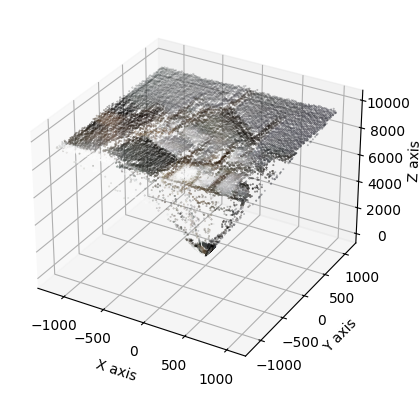

In [16]:
def depth_to_point_cloud(depth_map, rgb_image, scale=1000.0, focal_length=500.0):
    height, width = depth_map.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    z = depth_map * scale
    
    x = (x - width / 2.0) * z / focal_length
    y = (y - height / 2.0) * z / focal_length
    
    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)
    colors = rgb_image.reshape(-1, 3) / 255.0  # Normalize to [0, 1]

    return points, colors

def generate_3d_point_cloud(model, edge_image_path, transform=None, device='cuda'):
    model.to(device)
    model.eval()
    
    edge_image = Image.open(edge_image_path).convert('L')
    if transform:
        edge_image = transform(edge_image)
    edge_image = edge_image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        depth_output, rgb_output = model(edge_image)
    
    depth_output = depth_output.squeeze(0).cpu().numpy()
    rgb_output = rgb_output.squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    # Normalize depth to range [0, 1]
    depth_output = (depth_output - depth_output.min()) / (depth_output.max() - depth_output.min())
    # Scale depth for better visualization (optional, depends on your data)
    depth_output = depth_output * 10  # You can adjust the scale factor
    
    # Normalize RGB to range [0, 255] and convert to uint8
    rgb_output = (rgb_output * 255).astype(np.uint8)
    
    points, colors = depth_to_point_cloud(depth_output[0], rgb_output)
    
    return points, colors

def visualize_point_cloud_matplotlib(points, colors):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=0.1)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    plt.show()

# Example usage
edge_image_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\edge\1.png'

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load the trained model
load_model = UNet()
load_model.load_state_dict(torch.load('model_weights_2.pth'))

# Generate 3D point cloud
points, colors = generate_3d_point_cloud(load_model, edge_image_path, transform=transform)

# Visualize the point cloud using Matplotlib
visualize_point_cloud_matplotlib(points, colors)

In [17]:
def visualize_point_cloud_open3d(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    o3d.visualization.draw_geometries([pcd])

# Use this instead of the matplotlib visualization
visualize_point_cloud_open3d(points, colors)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
